In [18]:
import pandas as pd

# Load the CSV file
csv_path = '/content/project_major.csv'
df = pd.read_csv(csv_path)

# Assign labels: first 474 images are healthy (label = '1'), remaining 291 are unhealthy (label = '0')
df['label'] = ['1'] * 474 + ['0'] * 291

# Replace backslashes with forward slashes in the image paths
df['image_path'] = df['image_path'].str.replace('\\', '/')

# Function to correct paths
def correct_path(image_path):
    base_dir = '/content/drive/MyDrive/both_images2'  # Adjust this based on your environment
    filename = os.path.basename(image_path)  # Extract the filename
    return os.path.join(base_dir, filename)  # Construct the new path

# Apply the function to the 'image_path' column
df['image_path'] = df['image_path'].apply(correct_path)

# Verify the changes
print(df.head())

# Save the updated CSV (optional)
df.to_csv('/content/project_corrected.csv', index=False)

# Check if the new paths are valid
invalid_paths = [path for path in df['image_path'] if not os.path.exists(path)]
print(f"Number of invalid paths: {len(invalid_paths)}")

# Display some invalid paths if there are any
for path in invalid_paths[:10]:
    print(path)

if len(invalid_paths) > 0:
    print("There are still invalid paths. Please check the directory and filenames.")
else:
    print("All paths are valid.")


                                          image_path label
0  /content/drive/MyDrive/both_images2/healthy (1...     1
1  /content/drive/MyDrive/both_images2/healthy (1...     1
2  /content/drive/MyDrive/both_images2/healthy (1...     1
3  /content/drive/MyDrive/both_images2/healthy (1...     1
4  /content/drive/MyDrive/both_images2/healthy(10...     1
Number of invalid paths: 170
/content/drive/MyDrive/both_images2/healthy(10).jpeg
/content/drive/MyDrive/both_images2/healthy.png
/content/drive/MyDrive/both_images2/healthy(101).jpg
/content/drive/MyDrive/both_images2/healthy.jpg
/content/drive/MyDrive/both_images2/healthy.jpg
/content/drive/MyDrive/both_images2/healthy(105).jpg
/content/drive/MyDrive/both_images2/healthy(107).jpg
/content/drive/MyDrive/both_images2/healthy(11).jpeg
/content/drive/MyDrive/both_images2/healthy(11).jpg
/content/drive/MyDrive/both_images2/healthy (113).jpg
There are still invalid paths. Please check the directory and filenames.


In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ensure labels are strings
df['label'] = df['label'].astype(str)

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)


Found 478 validated image filenames belonging to 2 classes.
Found 116 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 134 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 37 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model built and compiled.")


Model built and compiled.


In [22]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
15/15 [==============================] - 207s 14s/step - loss: 0.8271 - accuracy: 0.5921 - val_loss: 0.6101 - val_accuracy: 0.6121
Epoch 2/10
15/15 [==============================] - 27s 2s/step - loss: 0.3906 - accuracy: 0.8494 - val_loss: 0.2487 - val_accuracy: 0.8966
Epoch 3/10
15/15 [==============================] - 24s 2s/step - loss: 0.2594 - accuracy: 0.8954 - val_loss: 0.3347 - val_accuracy: 0.8448
Epoch 4/10
15/15 [==============================] - 27s 2s/step - loss: 0.2095 - accuracy: 0.9184 - val_loss: 0.2100 - val_accuracy: 0.9310
Epoch 5/10
15/15 [==============================] - 22s 1s/step - loss: 0.1666 - accuracy: 0.9310 - val_loss: 0.1989 - val_accuracy: 0.9483
Epoch 6/10
15/15 [==============================] - 24s 2s/step - loss: 0.1350 - accuracy: 0.9582 - val_loss: 0.1664 - val_accuracy: 0.9483
Epoch 7/10
15/15 [==============================] - 23s 2s/step - loss: 0.1064 - accuracy: 0.9623 - val_loss: 0.1507 - val_accuracy: 0.9483
Epoch 8/10
15/15 [

In [23]:
# Save the model
model.save('/content/scalp_psoriasis_model.h5')
print("Model trained and saved.")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model trained and saved.


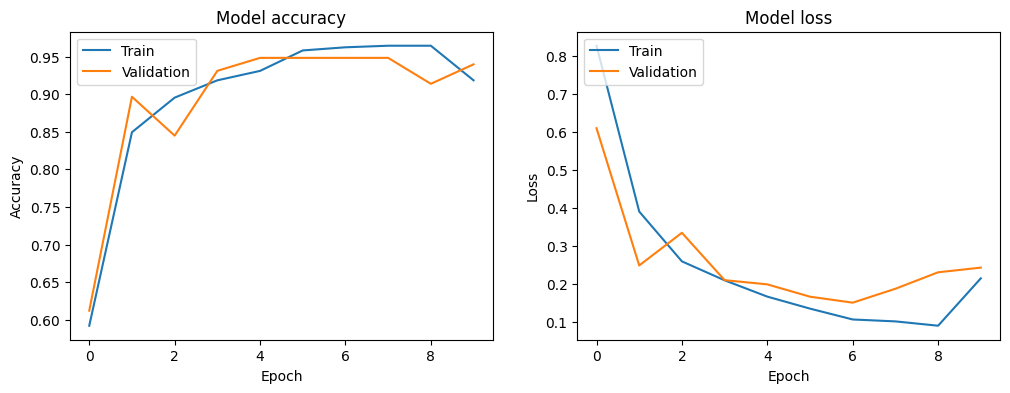

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation set
val_predictions = model.predict(val_generator)
val_predictions = np.where(val_predictions > 0.5, 1, 0)  # Convert probabilities to class labels

# Get true labels
val_true_labels = val_generator.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


4/4 [==============================] - 2s 419ms/step
Confusion Matrix:
[[35 23]
 [28 30]]


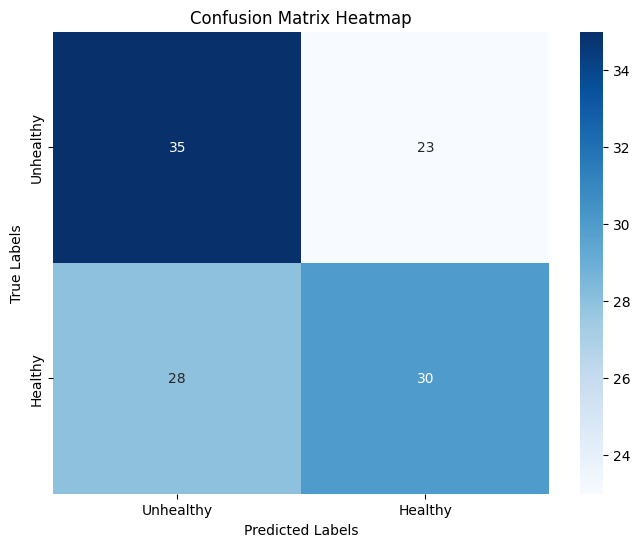

In [29]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Unhealthy', 'Healthy'], yticklabels=['Unhealthy', 'Healthy'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [31]:
#prediction of model with user input
from tensorflow.keras.preprocessing import image
import numpy as np

def classify_image(img_path, model):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    print("your scalp is",end=" ")
    if prediction < 0.5:
        print("Unhealthy")
    else:
        print("Healthy")

# Example usage
classify_image('/content/drive/MyDrive/both_images2/healthy (1).jpeg', model)


1/1 [==============================] - 0s 38ms/step
your scalp is Healthy


In [32]:
#prediction of model with user input
from tensorflow.keras.preprocessing import image
import numpy as np

def classify_image(img_path, model):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    print("your scalp is",end=" ")
    if prediction < 0.5:
        print("Unhealthy")
    else:
        print("Healthy")

# Example usage
classify_image('/content/unhealthy (2).jpg', model)


1/1 [==============================] - 0s 66ms/step
your scalp is Unhealthy


In [27]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


4/4 [==============================] - 2s 332ms/step - loss: 0.2430 - accuracy: 0.9397
Validation Accuracy: 93.97%
